# From NIR to SpiNNaker2

*(this notebook is based on the [Speck demo](https://github.com/Jegp/NIR-demo-repo/blob/main/speck_demo/demo.ipynb) by Felix Bauer)*

In this notebook we will show how a NIR model can be deployed onto the SpiNNaker2 chip. 

[py-spinnaker2](https://gitlab.com/spinnaker2/py-spinnaker2), the high-level software interface for running spiking neural networks on SpiNNaker2, provides an API similar to [PyNN](http://neuralensemble.org/docs/PyNN/) and allows to define populations (groups of neurons with the same neuron model) and projections (group of synapses between two populations).

In [1]:
# Import statements
from matplotlib import pyplot as plt
import nir
import numpy as np
import tonic
import torch
from tqdm.notebook import tqdm
from spinnaker2 import brian2_sim, hardware, s2_nir, snn

# Matplotlib settings
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 20

## Load NIR model from disk

In [2]:
model_path = "scnn_mnist.nir"
nir_graph = nir.read(model_path)

# make sure all nodes have necessary shape information
nir_graph.infer_types()
s2_nir.model_summary(nir_graph)

[warning] 4.input_type undefined, set to 3.output_type
[warning] 7.input_type undefined, set to 6.output_type
input <class 'nir.ir.Input'> {'input': array([ 2, 34, 34])} {'output': array([ 2, 34, 34])} -> ['0']
0 <class 'nir.ir.Conv2d'> {'input': array([ 2, 34, 34])} {'output': array([16, 16, 16])} -> ['1']
1 <class 'nir.ir.IF'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['2']
2 <class 'nir.ir.Conv2d'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['3']
3 <class 'nir.ir.IF'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['4']
4 <class 'nir.ir.SumPool2d'> {'input': array([16, 16, 16])} {'output': array([16,  8,  8])} -> ['5']
5 <class 'nir.ir.Conv2d'> {'input': array([16,  8,  8])} {'output': array([8, 8, 8])} -> ['6']
6 <class 'nir.ir.IF'> {'input': array([8, 8, 8])} {'output': array([8, 8, 8])} -> ['7']
7 <class 'nir.ir.SumPool2d'> {'input': array([8, 8, 8])} {'output': array([8, 4, 4])} -> ['8']
8 <class 'nir.ir.Flatten'>

## Convert NIR graph into py-spinnaker2 network

Let's convert the nir graph into a `spinnaker2.snn.Network()`.

In [3]:
# Configuration for converting NIR graph to SpiNNaker2
conversion_cfg = s2_nir.ConversionConfig()
conversion_cfg.output_record = ["v", "spikes"]
conversion_cfg.dt = 0.0001
conversion_cfg.conn_delay = 0
conversion_cfg.scale_weights = True # Scale weights to dynamic range on chip
conversion_cfg.reset = s2_nir.ResetMethod.ZERO # Reset voltage to zero at spike
conversion_cfg.integrator = s2_nir.IntegratorMethod.FORWARD # Euler-Forward

net, inp, outp = s2_nir.from_nir(nir_graph, conversion_cfg)

INFO:spinnaker2.s2_nir:from_nir(): create spinnaker2.Network from NIR graph
INFO:spinnaker2.s2_nir:Created 6 populations: ['1', '10', '12', '3', '6', 'input']


Node '0'
Got <class 'nir.ir.Conv2d'>
input:  [('input', <class 'nir.ir.Input'>)]
output:  [('1', <class 'nir.ir.IF'>)]

Node '1'
Got <class 'nir.ir.IF'>
record:  []
[16 16 16] -> [16 16 16]
input:  [('0', <class 'nir.ir.Conv2d'>)]
output:  [('2', <class 'nir.ir.Conv2d'>)]

Node '10'
Got <class 'nir.ir.IF'>
record:  []
[256] -> [256]
input:  [('9', <class 'nir.ir.Affine'>)]
output:  [('11', <class 'nir.ir.Affine'>)]

Node '11'
Got <class 'nir.ir.Affine'>
input:  [('10', <class 'nir.ir.IF'>)]
output:  [('12', <class 'nir.ir.IF'>)]

Node '12'
Got <class 'nir.ir.IF'>
['v', 'spikes']
record:  ['v', 'spikes']
[10] -> [10]
input:  [('11', <class 'nir.ir.Affine'>)]
output:  [('output', <class 'nir.ir.Output'>)]

Node '2'
Got <class 'nir.ir.Conv2d'>
input:  [('1', <class 'nir.ir.IF'>)]
output:  [('3', <class 'nir.ir.IF'>)]

Node '3'
Got <class 'nir.ir.IF'>
record:  []
[16 16 16] -> [16 16 16]
input:  [('2', <class 'nir.ir.Conv2d'>)]
output:  [('4', <class 'nir.ir.SumPool2d'>)]

Node '4'
Got <cl

INFO:spinnaker2.s2_nir:Created 5 projections: ['Projection_0', 'Projection_1', 'Projection_2', 'Projection_3', 'Projection_4']


{'in_height': 16, 'in_width': 16, 'stride_x': 1, 'stride_y': 1, 'pool_x': 1, 'pool_y': 1, 'pad_top': 1, 'pad_bottom': 1, 'pad_left': 1, 'pad_right': 1} weights:  (16, 16, 3, 3)


### Load the neuromorphic MNIST dataset

Let's quickly run the test set through the sinabs model to make sure everything works as it should.

In [4]:
# load dataset
to_frame = tonic.transforms.ToFrame(
    sensor_size=tonic.datasets.NMNIST.sensor_size, time_window=1e3
)
dataset = tonic.datasets.NMNIST(".", transform=to_frame, train=False)

# Only use every 200th sample
indices = torch.arange(50) * 200
subset = torch.utils.data.Subset(dataset, indices)

## Deploy the model onto SpiNNaker2

Deploying a model onto SpiNNaker2 looks as follows:

### Customize neurons per core

In [5]:
# Customize neurons per core per population
for pop in net.populations:
    if pop.name == "3":
        pop.set_max_atoms_per_core(256)
    if pop.name == "6":
        pop.set_max_atoms_per_core(128)
    if pop.name == "10":
        pop.set_max_atoms_per_core(16)

### Convert input data to spikes
While the torch dataset uses tensors, py-spinnaker2's input populations of type `spike_list` require spike times as input. Here's the conversion function that also considers flattening of the 3-dimensional frames

In [6]:
def convert_input(x):
    d = {}
    # T = x.shape[0]
    C = x.shape[1]
    H = x.shape[2]
    W = x.shape[3]
    for c in range(C):
        for h in range(H):
            for w in range(W):
                d[c * H * W + h * W + w] = x[:, c, h, w].nonzero()[0].tolist()
    return d

Function to run one sample on the chip and return voltages and spikes of output layer.

In [7]:
def run_single(hw, net, inp, outp, x):
    """run single sample on SpiNNaker2
    
    Args:
      hw: spinnaker2.Hardware instance
      net: spinnaker2 Network
      inpu: list of input populations
      outp: list of output populations
      x: input sample of shape (T,C,H,W)
      
    Returns:
      tuple (voltages, spikes): voltages and spikes of output layer
    """
    input_spikes = convert_input(x)
    inp[0].params = input_spikes

    timesteps = x.shape[0] + 1
    net.reset()
    hw.run(net, timesteps, sys_tick_in_s=2.5e-3, debug=False)
    voltages = outp[0].get_voltages()
    spikes = outp[0].get_spikes()

    return voltages, spikes

### Some helper functions

In [8]:
# This will help us choose samples of a given target
targets = np.array([y for x,y in subset])
target_indices = {idx: np.where(targets == idx)[0] for idx in range(10)}

def plot_hist(output_spikes, target):
    # spike count
    spike_counts = np.zeros(10)
    for idx, spikes in output_spikes.items():
        spike_counts[idx] = len(spikes)
    prediction = np.argmax(spike_counts)


    # Draw histogram
    fig, ax = plt.subplots()
    bins = np.arange(11)-0.5
    # N, bins, patches = ax.hist(features, bins=bins, edgecolor='white', linewidth=1)
    patches = ax.bar(np.arange(10), spike_counts, edgecolor='white', linewidth=1)
    plt.title(f"Prediction: {prediction} ({f'target: {target}' if target!=prediction else 'correct'})")
    plt.ylabel("Event count")
    plt.xlabel("Feature")
    plt.xticks(np.arange(10));
    
    # Set bar colors according to prediction and target
    for i, patch in enumerate(patches):
        if i == prediction and i == target:
            patch.set_facecolor('g')
        elif i == prediction:
            patch.set_facecolor('r')
        elif i == target:
            patch.set_facecolor('k')
    
    # Make xtick label of prediciton bold
    ax.xaxis.get_major_ticks()[prediction].label1.set_fontweight("bold")

    return prediction

def test_sample(target):
    index = np.random.choice(target_indices[target])
    sample, tgt = subset[index]
    assert(target == tgt)
    image = sample.sum((0, 1))
    plt.imshow(image)
    plt.title("Input")
    
    # run on SpiNNaker 2
    hw = hardware.SpiNNaker2Chip(eth_ip="192.168.1.25")
    # hw = brian2_sim.Brian2Backend()

    voltages, spikes = run_single(hw, net, inp, outp, sample)
    del hw
    
    prediction = plot_hist(spikes, target)
    print(f"SpiNNaker2 prediction: {prediction}")

## Live demo

Now let's run the example on the SpiNNaker2 chip:

cores available: 152
cores needed:    46
Used 46 out of 152 cores
Sim duration: 0.765 s
Actual duration (incl. offset): 0.775


INFO:     open and bind UDP socket
INFO:     Running test ...


configure hardware
There are 12QPEs
Enabled QPEs.
Enabled random bus


INFO:     start random bus...
INFO:     QPE (1,1) PE 0): loading memory from file /home/vogginger/project/software/s2-sim2lab-app/chip/app-pe/s2app/lif_conv2d/binaries/s2app_arm.mem...
INFO:     QPE (1,1) PE 1): loading memory from file /home/vogginger/project/software/s2-sim2lab-app/chip/app-pe/s2app/lif_conv2d/binaries/s2app_arm.mem...
INFO:     QPE (1,1) PE 2): loading memory from file /home/vogginger/project/software/s2-sim2lab-app/chip/app-pe/s2app/lif_conv2d/binaries/s2app_arm.mem...
INFO:     QPE (1,1) PE 3): loading memory from file /home/vogginger/project/software/s2-sim2lab-app/chip/app-pe/s2app/lif_conv2d/binaries/s2app_arm.mem...
INFO:     QPE (1,2) PE 0): loading memory from file /home/vogginger/project/software/s2-sim2lab-app/chip/app-pe/s2app/lif_neuron_no_delay/binaries/s2app_arm.mem...
INFO:     QPE (1,2) PE 1): loading memory from file /home/vogginger/project/software/s2-sim2lab-app/chip/app-pe/s2app/lif_neuron_no_delay/binaries/s2app_arm.mem...
INFO:     QPE (1,2) PE

Loaded mem-files
Data written to SRAM
PEs started
Sending regfile interrupts for synchronous start
Run experiment for 0.775 seconds
Experiment done
Going to read 3060 from address 0xf0712c90 (key: PE_56_spike_record)
Going to read 3366 from address 0xf0715c60 (key: PE_56_voltage_record)
Results read
interface free again
Read spike record
read_spikes(n_neurons=10, time_steps=306, max_atoms=250)
Read voltage record
read_voltages(n_neurons=10, time_steps=306)
Duration recording: 0.04162883758544922
SpiNNaker2 prediction: 2


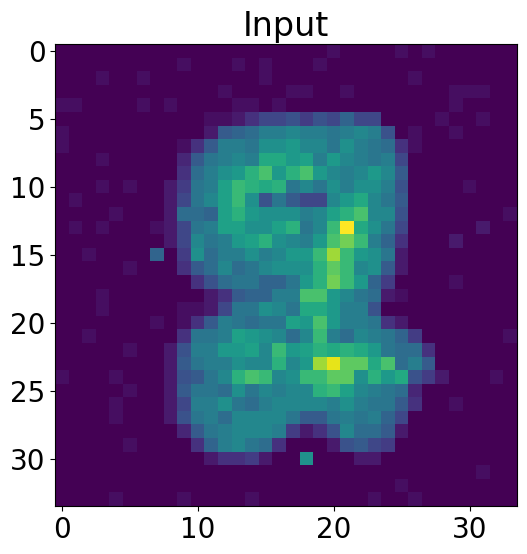

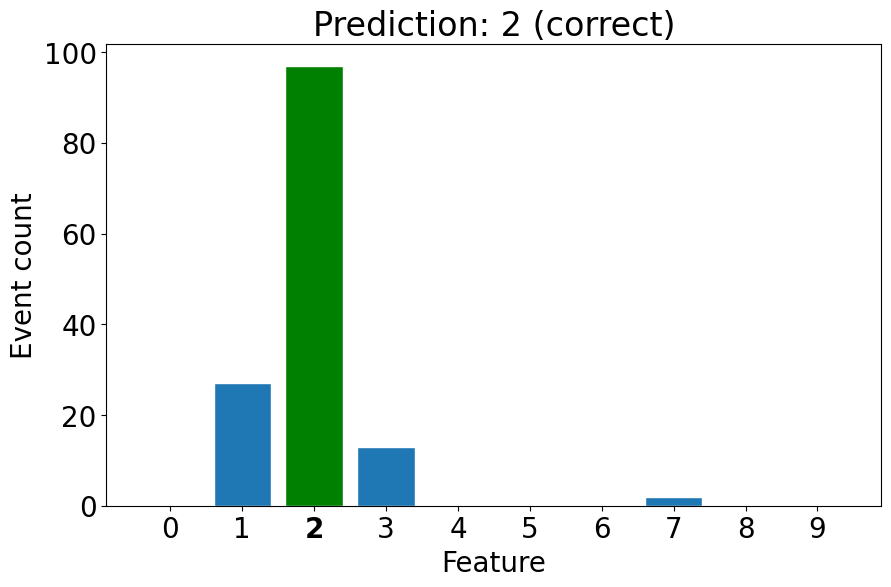

In [9]:
test_sample(2)

## Send test data to the chip and read out its prediction
To get some quantitative idea about how well the on-chip model does, we can use the test data from above and run it through the chip. **Note: this will take more than 6 minutes!!!**

In [10]:
def run_subset():
    correct = 0
    predictions = []
    for (sample, target) in tqdm(subset, total=len(subset)):

        # run on SpiNNaker 2
        hw = hardware.SpiNNaker2Chip(eth_ip="192.168.1.25")
        # hw = brian2_sim.Brian2Backend()

        voltages, spikes = run_single(hw, net, inp, outp, sample)
        del hw

        spike_counts = np.zeros(10)
        for idx, spike_times in spikes.items():
            spike_counts[idx] = len(spike_times)
        prediction = np.argmax(spike_counts)

        correct += (prediction == target)
        predictions.append(prediction)

    accuracy = correct / len(subset)
    print(f"Test accuracy on SpiNNaker2: {accuracy:.2%}")

In [11]:
# run_subset()